# Performance Analysis

We will investigate the performance of the recursive `eval` query in a number of
different ways:

- Scaling the number of hidden units
- Scaling the number of layers
- Scaling the input length (length of a single input vector)
- Scaling the input size (number of input vectors)

Before we start on this, we'll see if we can make the `eval` query more
performant.

## Preliminaries

The queries we'll test can be found
[here](./queries/eval_recursive_from_input.sql) (regular version) and
[here](./queries/eval_recursive_from_input_optim.sql) (optimized version). We go
over the differences in a later section.

In [2]:
import utils.duckdb as db
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.perftest as perftest

with open('queries/eval_recursive_from_input.sql') as file:
    eval_query_regular = file.read()

with open('queries/eval_recursive_from_input_optim.sql') as file:
    eval_query_opt = file.read()

We'll also set up an empty database.

In [3]:
def reset_db():
    db._initialize_database()

reset_db()

And some code to set up a random neural network with specific dimensions.

In [4]:
def create_network(num_input_nodes, num_nodes_per_layer, num_hidden_layers, num_output_nodes):
    def nodes():
        node_id = 1

        for i in range(0, num_input_nodes):
            yield [node_id, 0, f"input.{i}"]
            node_id += 1

        for layer in range(0, num_hidden_layers):
            for i in range(num_nodes_per_layer):
                bias = random.uniform(-10, 10)
                yield [node_id, bias, f"layer_{layer}.{i}"]
                node_id += 1

        for i in range(0, num_output_nodes):
            bias = random.uniform(-10, 10)
            yield [node_id, bias, f"output.{i}"]
            node_id += 1

    def edges():
        # Insert edges from input nodes to first hidden layer
        for i_from in range(0, num_input_nodes):
            for i_to in range(num_input_nodes, num_input_nodes + num_nodes_per_layer):
                from_node_id = i_from + 1
                to_node_id = i_to + 1
                weight = random.uniform(-10, 10)
                yield [from_node_id, to_node_id, weight]

        # Insert edges between hidden nodes
        for layer in range(0, num_hidden_layers - 1):
            for i_from in range(0, num_nodes_per_layer):
                for i_to in range(0, num_nodes_per_layer):
                    from_node_id = num_input_nodes + (layer * num_nodes_per_layer) + i_from + 1
                    to_node_id = num_input_nodes + ((layer + 1) * num_nodes_per_layer) + i_to + 1
                    weight = random.uniform(-10, 10)
                    yield [from_node_id, to_node_id, weight]

        # And finally, insert edges from the last hidden layer to the output nodes
        for i_from in range(0, num_nodes_per_layer):
            for i_to in range(0, num_output_nodes):
                from_node_id = num_input_nodes + ((num_hidden_layers - 1) * num_nodes_per_layer) + i_from + 1
                to_node_id = num_input_nodes + (num_hidden_layers * num_nodes_per_layer) + i_to + 1
                weight = random.uniform(-10, 10)
                yield [from_node_id, to_node_id, weight]

    db.batch_insert(nodes(), "node")
    db.batch_insert(edges(), "edge")

And a utility function that creates random input values.

In [5]:
def create_random_input(num_input_nodes, num_input_sets):
    def input_generator():
        for input_set_id in range(0, num_input_sets):
            for input_node_idx in range(0, num_input_nodes):
                yield [input_set_id, input_node_idx, random.uniform(-10, 10)]


    db.con.execute("TRUNCATE TABLE input")
    df = pd.DataFrame(input_generator())
    db.con.execute(f"INSERT INTO input SELECT * FROM df")

For the testing of performance, we set up [a small
framework](./utils/perftest.py). It allows us to easily run tests multiple
times, to average out the results.

## Performance optimizations

There are a few performance optimizations we can do on the original `eval`
query. It boils down to this:

- Replacing `NOT IN` with `NOT EXISTS`
- Changing the join order to set the smallest relation first

Specifically, we change occurrences of:

```sql
WHERE id NOT IN
(SELECT src FROM edge)
```

with:

```sql
WHERE NOT EXISTS
(SELECT 1 FROM edge WHERE dst = n.id)
```

And we change the join order in `tx` from:

```sql
FROM edge e
JOIN input_nodes i ON i.id = e.src
JOIN node n ON e.dst = n.id
JOIN input_values v ON i.input_node_idx = v.input_node_idx
```

to:

```sql
FROM input_nodes i
JOIN input_values v ON i.input_node_idx = v.input_node_idx
JOIN edge e ON i.id = e.src
JOIN node n ON e.dst = n.id
GROUP BY e.dst, n.bias, v.input_set_id
```

With similar ordering changes in other places. We'll compare the two version to
show there is a definite performance gain.

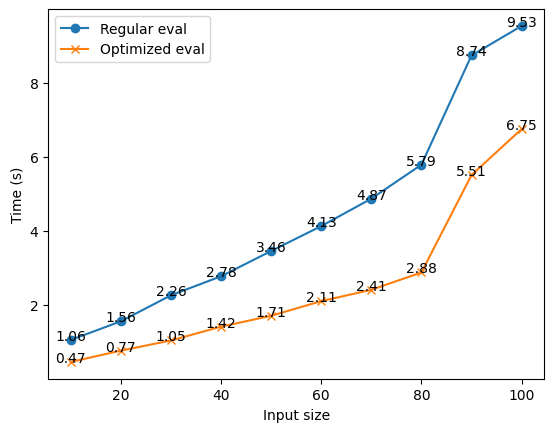

In [6]:
class EvalPerfTest(perftest.PerfTest):
    def setup_all(self):
        reset_db()
        create_network(num_input_nodes=28*28, num_nodes_per_layer=1000, num_hidden_layers=5, num_output_nodes=10)

    def setup_run(self, n):
        create_random_input(28*28, n)

    def x_labels(self):
        return [i*10 for i in range(1, 11)]


class RegularEval(EvalPerfTest):
    def run(self, n):
        results = db.con.execute(eval_query_regular).fetchall()


class OptimizedEval(EvalPerfTest):
    def run(self, n):
        results = db.con.execute(eval_query_opt)


df_regular = perftest.measure_performance(RegularEval())
df_opt = perftest.measure_performance(OptimizedEval())

perftest.plot_dfs(
    [
        (df_regular, "Regular eval", "o"),
        (df_opt, "Optimized eval", "x")
    ],
    "Input size"
)


We can see that the optimized version is roughly 1.5x as efficient. For all
following tests, we'll use the optimized version.

## Scaling the number of hidden units

We test the performance of the `eval` query when we scale the number of hidden
nodes per layer. For this we'll try two versions:

- 28*28 input length (MNIST size), 4 hidden layers
- 28*28 input length, 10 hidden layers.

For both we check 5K, 10K, 15K, and 20K hidden units per layer.

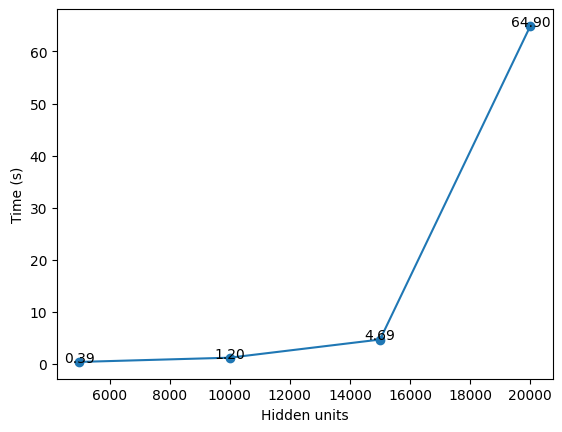

In [7]:
class HiddenUnits4(perftest.PerfTest):
    def setup_all(self):
        create_random_input(28*28, 1)

    def setup_run(self, hidden_units):
        reset_db()
        create_network(
            num_input_nodes=28*28,
            num_nodes_per_layer=hidden_units,
            num_hidden_layers=4,
            num_output_nodes=10
        )

    def run(self, x):
        results = db.con.execute(eval_query_opt)

    def x_labels(self):
        return [5_000, 10_000, 15_000, 20_000]

df_hidden_units_4 = perftest.measure_performance(HiddenUnits4())
perftest.plot_df(df_hidden_units_4, "Hidden units")

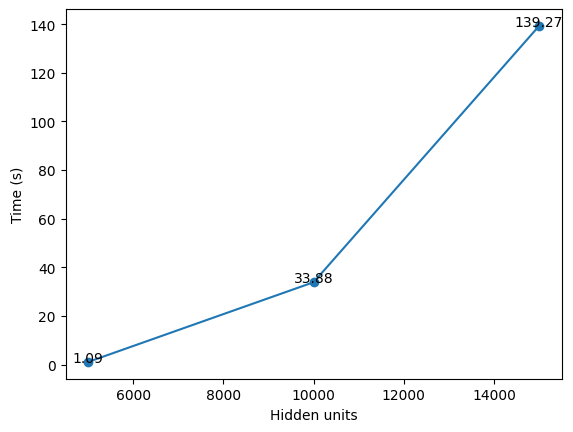

In [8]:
class HiddenUnits10(perftest.PerfTest):
    def setup_all(self):
        create_random_input(28*28, 1)

    def setup_run(self, hidden_units):
        reset_db()
        create_network(
            num_input_nodes=28*28,
            num_nodes_per_layer=hidden_units,
            num_hidden_layers=10,
            num_output_nodes=10
        )

    def run(self, x):
        results = db.con.execute(eval_query_opt)

    def x_labels(self):
        return [5_000, 10_000, 15_000]

df_hidden_units_10 = perftest.measure_performance(HiddenUnits10())
perftest.plot_df(df_hidden_units_10, "Hidden units")

The original plan was to test 20K as well, but this didn't finish after 8h.
Also, lots of disk usage.

⚠ Error:

OutOfMemoryException: Out of Memory Error: failed to offload data block of size 256.0 KiB (57.6 GiB/57.6 GiB used).
This limit was set by the 'max_temp_directory_size' setting.
By default, this setting utilizes the available disk space on the drive where the 'temp_directory' is located.
You can adjust this setting, by using (for example) PRAGMA max_temp_directory_size='10GiB'

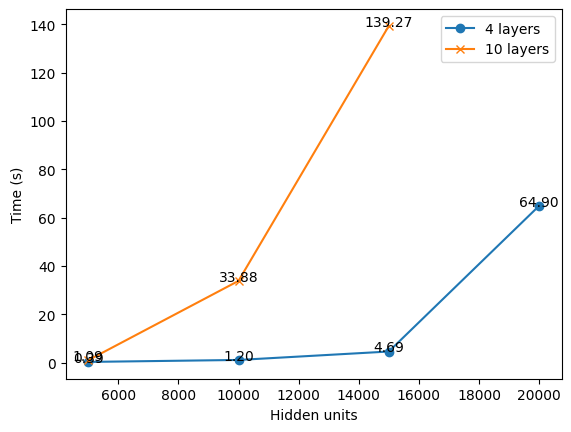

In [9]:
perftest.plot_dfs(
    [
        (df_hidden_units_4, "4 layers", "o"),
        (df_hidden_units_10, "10 layers", "x")
    ],
    "Hidden units"
)

## Scaling the number of layers

A typical neural network does not have a lot of layers. However, it can still be
interesting to see how our `eval` query scales with the number of
layers.

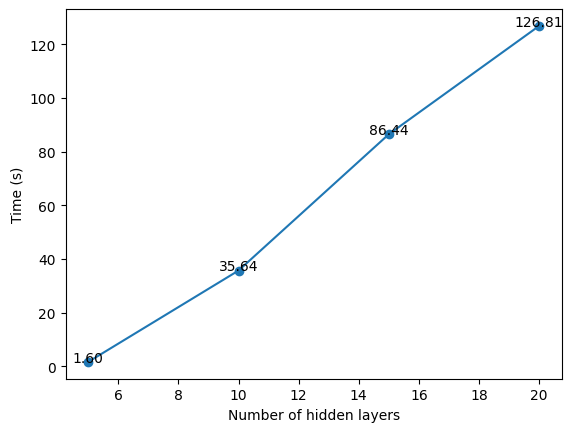

In [10]:
class HiddenLayers(perftest.PerfTest):
    def setup_all(self):
        create_random_input(28*28, 1)

    def setup_run(self, hidden_layers):
        reset_db()
        create_network(
            num_input_nodes=28*28,
            num_nodes_per_layer=10_000,
            num_hidden_layers=hidden_layers,
            num_output_nodes=10
        )

    def run(self, x):
        results = db.con.execute(eval_query_opt)

    def x_labels(self):
        return [5, 10, 15, 20]

df_hidden_layers = perftest.measure_performance(HiddenLayers())
perftest.plot_df(df_hidden_layers, "Number of hidden layers")

## Scaling the input length

We measure the performance when the input length (number of input nodes) is
increased.

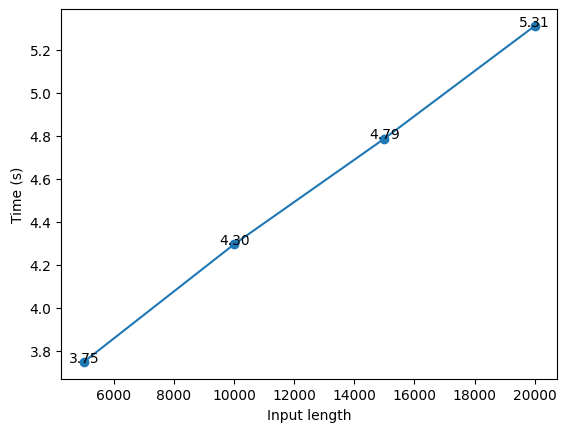

In [11]:
class InputLength(perftest.PerfTest):
    def setup_run(self, input_length):
        reset_db()
        create_network(
            num_input_nodes=input_length,
            num_nodes_per_layer=10_000,
            num_hidden_layers=4,
            num_output_nodes=10
        )
        create_random_input(input_length, 1)

    def run(self, x):
        results = db.con.execute(eval_query_opt)

    def x_labels(self):
        return [5_000, 10_000, 15_000, 20_000]

df_input_length = perftest.measure_performance(InputLength())
perftest.plot_df(df_input_length, "Input length")

## Scaling the input size

And lastly we check how the performance evolves when we scale up the input size
(= number of input vectors).

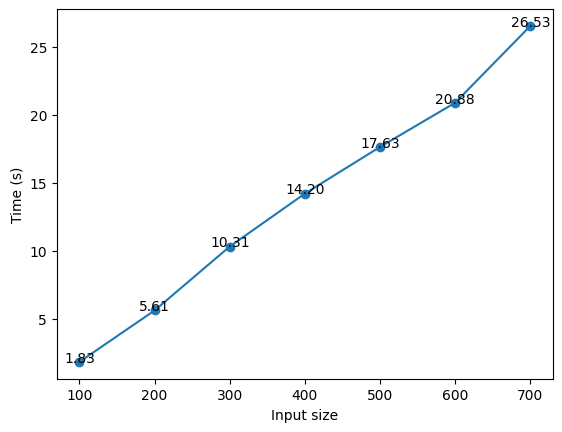

In [15]:
class InputSize(perftest.PerfTest):
    def setup_all(self):
        reset_db()
        create_network(
            num_input_nodes=28*28,
            num_nodes_per_layer=500,
            num_hidden_layers=4,
            num_output_nodes=10
        )

    def setup_run(self, input_sets):
        create_random_input(28*28, input_sets)

    def run(self, input_sets):
        results = db.con.execute(eval_query_opt)

    def x_labels(self):
        return [100, 200, 300, 400, 500, 600, 700]

df_input_size = perftest.measure_performance(InputSize())
perftest.plot_df(df_input_size, "Input size")

⚠ Note that we significantly downscaled the model size (only 500 hidden units)
and input size (max 700). This because our test PC started running into memory
issues.

## Recursive query

In the earlier notebooks, we started out with the non-recursive version of the
`eval` query. It might be interesting to see how the recursive version compares
to the non-recursive one.

We already have measurements for the recursive eval when scaling the input size,
so let's reuse the same testing scenario.

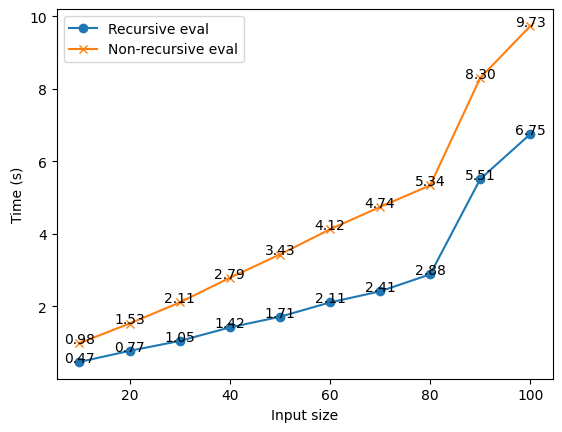

In [13]:
class NonRecursiveEval(EvalPerfTest):
    def run(self, n):
        num_layers = 5
        query = f"""
            WITH input_values AS (
                SELECT input_set_id, input_node_idx, input_value FROM input
            )
            input_nodes AS (
                SELECT
                    id,
                    bias,
                    ROW_NUMBER() OVER (ORDER BY id) AS input_node_idx
                FROM node
                WHERE NOT EXISTS
                (SELECT 1 FROM edge WHERE dst = n.id)
            ),
            t1 AS (
                SELECT
                    v.input_set_id AS input_set_id,
                    MAX(
                        0,
                        n.bias + SUM(e.weight * v.input_value)
                    ) AS t1,
                    e.dst AS id
                FROM edge e
                JOIN input_nodes i ON i.id = e.src
                JOIN node n ON e.dst = n.id
                JOIN input_values v ON i.input_node_idx = v.input_node_idx
                GROUP BY e.dst, n.bias, v.input_set_id
            ),
            """

        for hidden_layer in range(2, num_layers):
            curr = hidden_layer
            prev = hidden_layer - 1
            query += f"""
                t{curr} AS (
                    SELECT
                        t{prev}.input_set_id AS input_set_id,
                        MAX(
                            0,
                            n.bias + SUM(e.weight * t{prev}.t{prev})
                        ) AS t{curr},
                        e.dst AS id
                    FROM edge e
                    JOIN t{prev} ON t{prev}.id = e.src
                    JOIN node n ON e.dst = n.id
                    GROUP BY e.dst, n.bias, t{prev}.input_set_id
                ),
            """

        prev = num_layers - 1
        query += f"""
            outputs AS (
                SELECT
                    t{prev}.input_set_id AS input_set_id,
                    n.bias + SUM(e.weight * t{prev}.t{prev}) AS output_value,
                    e.dst AS output_node_id
                FROM edge e
                JOIN t{prev} ON t{prev}.id = e.src
                JOIN node n ON e.dst = n.id
                GROUP BY e.dst, n.bias, t{prev}.input_set_id
            )
            SELECT * FROM outputs ORDER BY input_set_id, output_node_id;
        """

        results = db.con.execute(eval_query_regular)

df_non_recursive = perftest.measure_performance(NonRecursiveEval())

perftest.plot_dfs(
    [
        (df_opt, "Recursive eval", "o"),
        (df_non_recursive, "Non-recursive eval", "x")
    ],
    "Input size"
)

We can see that the recursive eval is slightly faster. [This
notebook](./A.1%20Aside%20-%20DuckDB%20bugreport) also shows scaling issues
for the non-recursive version when increasing the number of layers.